Load in a pretrained resnet to see if that might produce better results than training our model from scratch.

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
import image_dataset
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create topk function
def topk_accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        # Get top k predictions.
        _, pred = output.topk(maxk, dim=1)

        # Find the predicted classes and transpose
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(torch.round(correct_k.mul_(1.0 / batch_size), decimals=4))
        return res

Successfully loaded datasets
Successfully loaded dataloaders
Using Device cpu
Starting training loop


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]                     


Training complete!


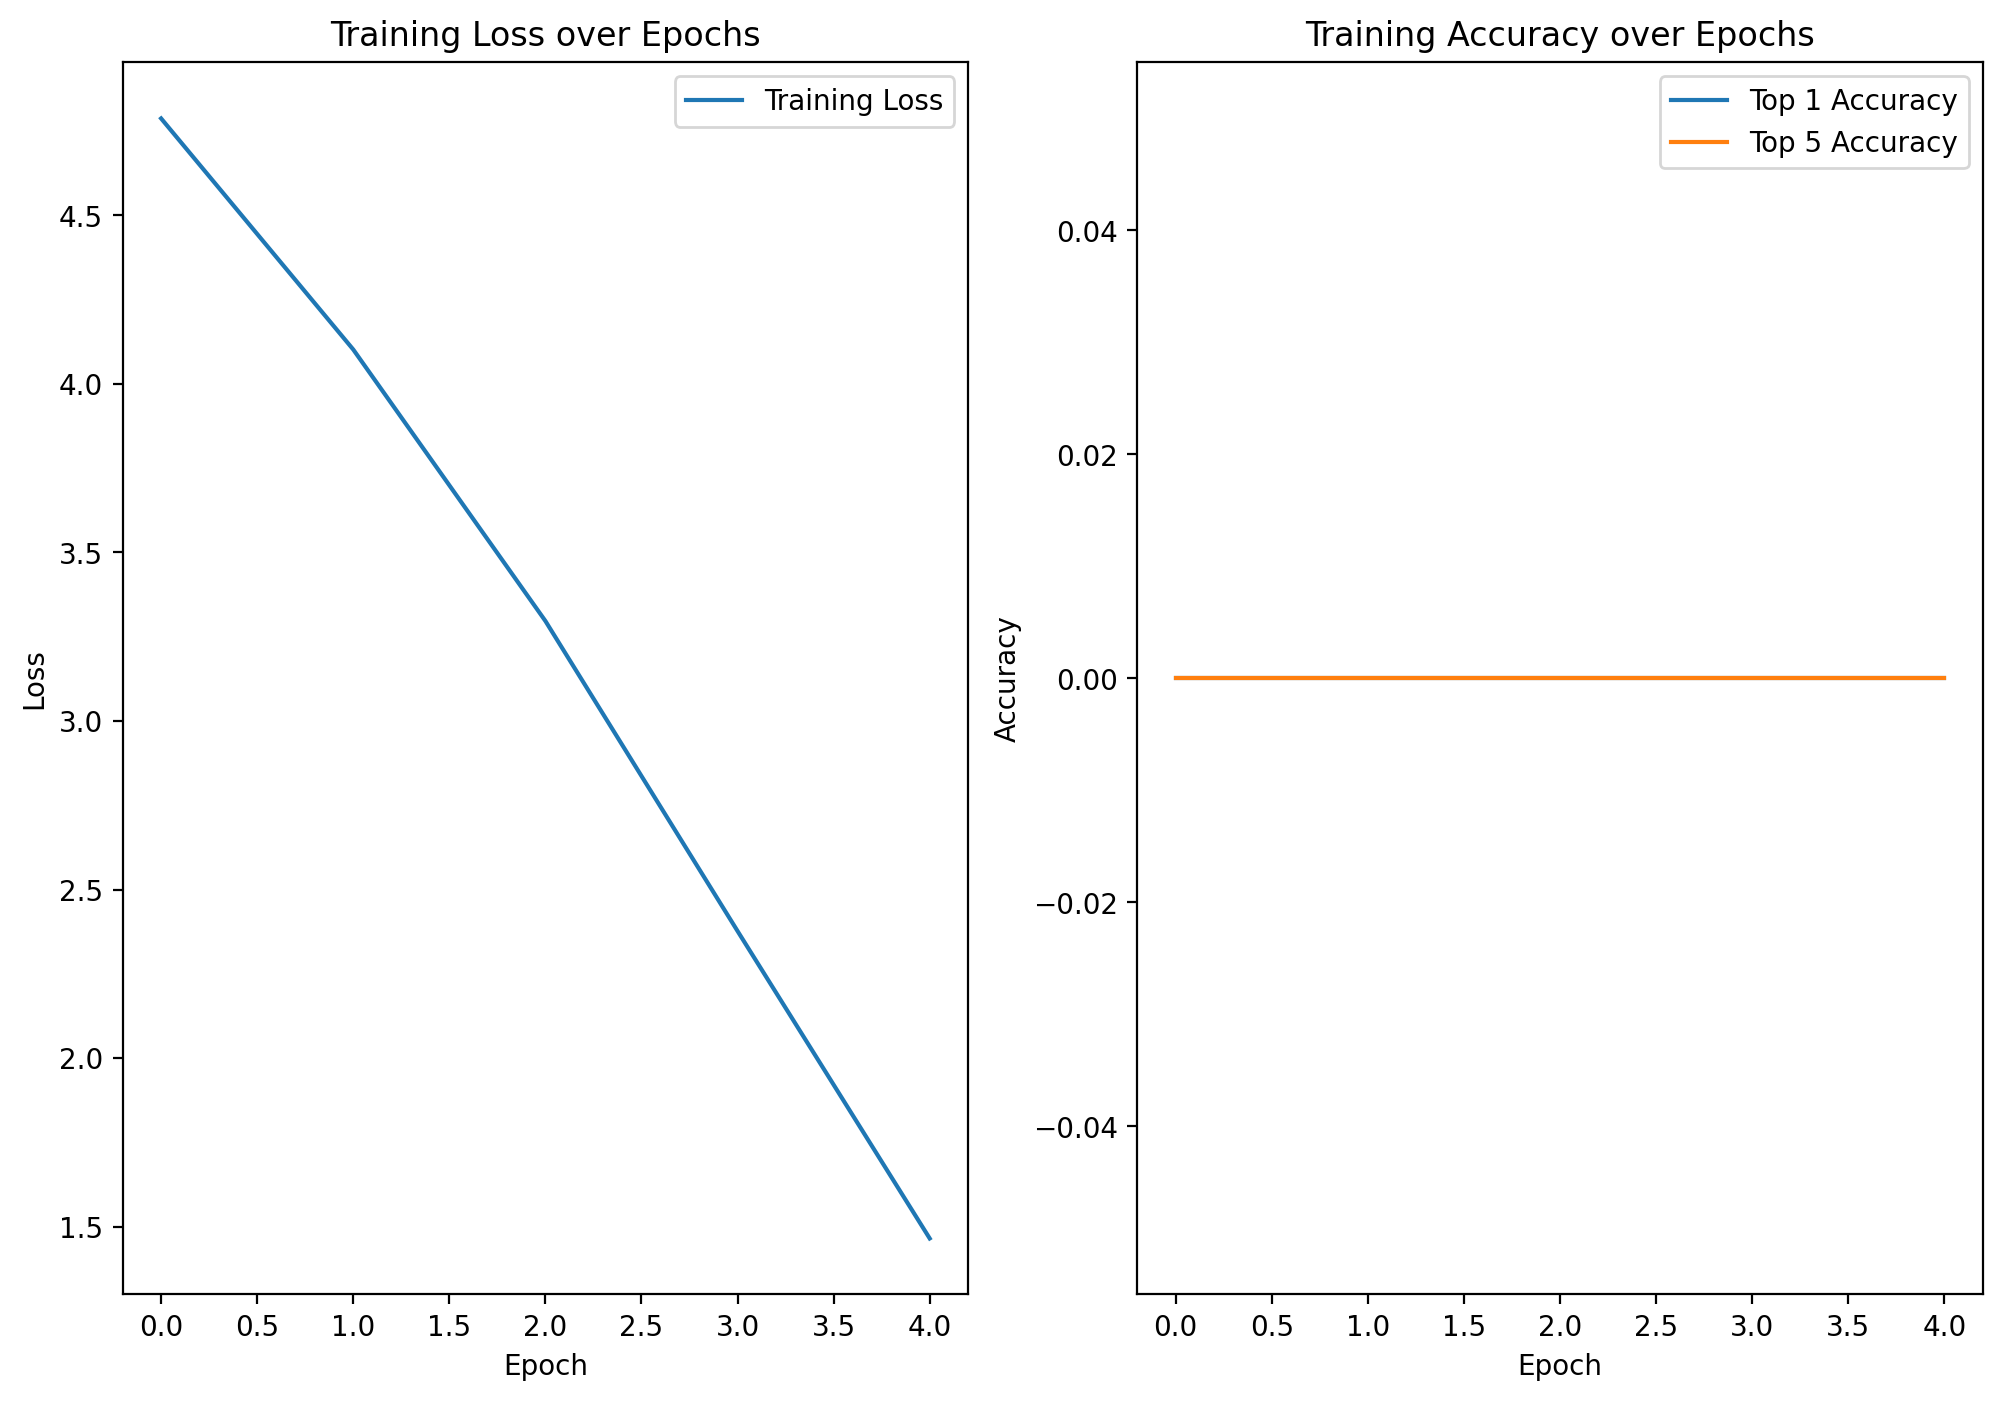

In [4]:
# Choose the variant of ResNet (e.g., ResNet-18)
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer for grayscale images
num_input_channels = 1  # Grayscale images have only one channel
model.conv1 = nn.Conv2d(num_input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Change the number out potential output classes.
num_classes = 1139
model.fc = nn.Linear(model.fc.in_features, num_classes)

train_dataset = image_dataset.ImageDataset(
    train=True, apply_equalize=False, apply_transform_train=True, transform=transforms.ToTensor())
test_dataset = image_dataset.ImageDataset(
    train=False, apply_equalize=False, apply_transform_test=True, transform=transforms.ToTensor())
print('Successfully loaded datasets')

    # Define the indices for the train and test sets
dataset_size = len(train_dataset)
split = int(0.8 * dataset_size)  # 80% for training, 20% for testing

indices = list(range(dataset_size))
train_indices, test_indices = indices[:split], indices[split:]

# Create data samplers for train and test sets
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoader instances using the samplers
batch_size = 30
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler)
print('Successfully loaded dataloaders')

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using Device', device)
model.to(device)

# Training loop
num_epochs = 5
train_losses = []  # List to store training losses
train_acc1 = []
train_acc5 = []
print('Starting training loop')

for epoch in range(num_epochs):
    model.train()
    tqdm_dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

    epoch_loss = 0.0  # Initialize the epoch loss

    for batch in tqdm_dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(labels)  # Accumulate loss for the entire epoch

        tqdm_dataloader.set_postfix(loss=loss.item())

    # Evaluate the model's accuracy
    model.eval()
    correct_top1 = 0
    correct_top5 = 0
    total = 0

    topk = (1, 5)  # You can adjust the top-k values as needed

    for batch in tqdm(test_dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)

        # Compute top-k accuracy
        topk_acc = topk_accuracy(outputs, labels, topk=topk)
        
        correct_top1 += topk_acc[0].item()
        correct_top5 += topk_acc[1].item()
        
        tqdm_dataloader.set_postfix(OrderedDict({'loss': loss.item(), 'top1_acc': topk_acc[0].item(), 'top5_acc': topk_acc[1].item()}))

        total += len(labels)

    # Calculate overall accuracy
    accuracy_top1 = correct_top1 / total
    accuracy_top5 = correct_top5 / total
    train_acc1.append(accuracy_top1)
    train_acc5.append(accuracy_top5)
    # tqdm_dataloader.set_postfix(loss=epoch_loss / len(train_dataloader.dataset), top1_acc=accuracy_top1, top5_acc=accuracy_top5)

    # Close the tqdm progress bar for the epoch
    tqdm_dataloader.close()

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataset)
    # Save the average epoch loss for plotting
    train_losses.append(avg_epoch_loss)

    # Print average epoch loss
    # print(f"Epoch {epoch + 1}/{num_epochs}, Avg. Loss: {avg_epoch_loss}, Top 1 Acc: {accuracy_top1}, Top 5 Acc: {accuracy_top5}")

# Training complete
print("Training complete!")

fig, ax = plt.subplots(1, 2, figsize=(12, 8), dpi=200)
ax[0].plot(train_losses, label='Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss over Epochs')
ax[0].legend()

ax[1].plot(train_acc1, label='Top 1 Accuracy')
ax[1].plot(train_acc5, label='Top 5 Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy over Epochs')
ax[1].legend()

plt.savefig('resnet18_test.png')


In [91]:
OrderedDict({'a': 1, 'b': 2})

OrderedDict([('a', 1), ('b', 2)])

In [78]:
topk = (1,3,4)
_, pred = outputs.topk(5, dim=1)
pred = pred.t()
correct = pred.eq(labels.view(1, -1).expand_as(pred))
# print(correct)

res = []
for k in topk:
    correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
    res.append(torch.round(correct_k.mul_(100.0 / batch_size), decimals=4))

f = F.softmax(outputs, dim=1)
topk_accuracy(f, labels, topk=(1,3,4))
# F.softmax(outputs, dim=1)


[tensor([0.]), tensor([0.]), tensor([0.])]